In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_loader import *
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [268]:

class ConvStep(nn.Module):
    def __init__(self,in_channels,mid_channels,out_channels):
        super(ConvStep,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels,mid_channels,kernel_size=3,padding=1,bias=False),
            #nn.BatchNorm1d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(mid_channels,out_channels,kernel_size=3,padding=1,bias=False),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,input):
        return self.conv(input)

class DownStep(nn.Module):
    def __init__(self,in_channels,mid_channels,out_channels):
        super(DownStep,self).__init__()
        self.down = nn.MaxPool1d(kernel_size=2)
        self.conv = ConvStep(in_channels,mid_channels,out_channels)
    def forward(self,input):
        input = self.down(input)
        input = self.conv(input)
        return input
    
class UpStep(nn.Module):
    def __init__(self,in_channels,mid_channels,out_channels):
        super(UpStep,self).__init__()
        self.up = nn.Upsample(scale_factor=2,mode='linear',align_corners=True)
        self.conv = ConvStep(in_channels,mid_channels,out_channels)
    def forward(self,i1,i2):
        #print("i1: ",i1.size())
        #print("i2: ",i2.size())
        i1 = self.up(i1)
        #print("i1: ",i1.size())

        dim1 = i2.size()[1] - i1.size()[1]
        dim2 = i2.size()[2] - i1.size()[2]

        i1 = F.pad(i1,(dim2//2,dim2-(dim2//2),dim1//2,dim1-(dim1//2)))
        #print("i1: ",i1.size())
        output = torch.cat([i2,i1],dim=1)
        #print("cat: ",output.size())
        output = self.conv(output)
        return output

class UNet(nn.Module):
    def __init__(self,inp_size=1):
        super(UNet,self).__init__()

        #input
        #first conv 3x3 relu
        #second conv 3x3 relu -> save a
        self.first_conv = ConvStep(inp_size,64,64)


        #max pool 2x2
        #conv 3x3 relu
        #conv 3x3 relu -> save b
        self.down1 = DownStep(64,128,128)

        #max pool 2x2
        #conv 3x3 relu
        #conv 3x3 relu -> save c
        self.down2 = DownStep(128,256,256)

        #max pool 2x2
        #conv 3x3 relu
        #conv 3x3 relu -> save d
        self.down3 = DownStep(256,512,512)

        #max pool 2x2
        #conv 3x3 relu
        #conv 3x3 relu
        self.down4 = DownStep(512,1024,1024//2)
        
        #up conv 2x2
        #concatenate prev and save d
        #conv 3x3 relu
        #conv 3x3 relu
        self.up1 = UpStep(1024,512,512//2)


        #up conv 2x2
        #concatenate prev and save c
        #conv 3x3 relu
        #conv 3x3 relu
        self.up2 = UpStep(512,256,256//2)


        #up conv 2x2
        #concatenate prev and save b
        #conv 3x3 relu
        #conv 3x3 relu
        self.up3 = UpStep(256,128,128//2)


        #up conv 2x2
        #concatenate prev and save a
        #conv 3x3 relu
        #conv 3x3 relu
        self.up4 = UpStep(128,64,64)


        #conv 1x1
        self.out = nn.Sequential(
            nn.Conv1d(64, inp_size, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self,input):
        a = self.first_conv(input)
        #_ = PrintLayer()(a)
        b = self.down1(a)
        #_ = PrintLayer()(b)
        c = self.down2(b)
        #_ = PrintLayer()(c)
        d = self.down3(c)
        #_ = PrintLayer()(d)

        bridge = self.down4(d)
        #_ = PrintLayer()(bridge)

        up = self.up1(bridge,d)
        #_ = PrintLayer()(up)
        up = self.up2(up,c)
        #_ = PrintLayer()(up)
        up = self.up3(up,b)
        #_ = PrintLayer()(up)
        up = self.up4(up,a)
        #_ = PrintLayer()(up)
        
        fix_dim = self.out(up)
        #_ = PrintLayer()(fix_dim)
        return fix_dim

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,num_residual_hidden,num_hidden_out):
        super(ResidualBlock,self).__init__()
        self.kernel_size = 3
        self.padding = (self.kernel_size)//2
        self.block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels,out_channels=num_residual_hidden,kernel_size=self.kernel_size,stride=1,padding=self.padding,bias=False),
            nn.BatchNorm1d(num_residual_hidden),
            nn.Tanh(),
            nn.Conv1d(in_channels=num_residual_hidden,out_channels=num_hidden_out,kernel_size=self.kernel_size,stride=1,padding=self.padding,bias=False),
            nn.BatchNorm1d(num_hidden_out),
        )
        self.tanh = nn.Tanh()
    def forward(self,x):
        outpt = self.block(x)
        return self.tanh(x + outpt)


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel,self).__init__()
        self.CHUNK = 1024
        self.hidden_len = self.CHUNK
        self.lstm = nn.LSTM(self.CHUNK,self.hidden_len,1,batch_first=True)
    def forward(self,input):
        N,C,T = input.shape
        num_iters = T // self.CHUNK
        hidden = torch.zeros(N,1,self.hidden_len).to(input.device)
        cell = torch.zeros(N,1,self.hidden_len).to(input.device)
        output = torch.tensor([], dtype=torch.float32, device=input.device)
        for i in range(num_iters):
            input_chunk = input[:,:,i*self.CHUNK:(i+1)*self.CHUNK]
            #input_chunk = nn.ConstantPad1d((0, self.CHUNK - input_chunk.shape[2]), 0)(input_chunk)
            #print(input_chunk.shape)
            out,(hidden,cell) = self.lstm(input_chunk,(hidden,cell))
            output = torch.cat([output,out], dim=2)
        return output

class TinyModel(nn.Module):
    def __init__(self):
        super(TinyModel,self).__init__()

        self.CHUNK = 1024*32
        in_length = self.CHUNK #105216


        def calc_padding(c, kernel_size,padding, dilation, stride):
            conv_len = int(((c+2*padding-dilation*(kernel_size-1)-1) / stride) + 1)
            other_padding = ((conv_len-1)*stride+dilation*(kernel_size-1)+1-c)//2
            return other_padding,conv_len
        
        def generate_convs(channels,kernel_sizes,strides,type):
            convs = []
            convtrans = []
            curr_len = in_length
            for i in range(len(kernel_sizes)):
                other_padding,curr_len = calc_padding(curr_len, kernel_sizes[i],(kernel_sizes[i]-1)//2,1,strides[i])
                if type[i]=='C':
                    a = nn.Conv1d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_sizes[i], stride=strides[i], padding=(kernel_sizes[i]-1)//2, bias=True)
                else:
                    a = nn.MaxPool1d(kernel_size=kernel_sizes[i], stride=strides[i], padding=(kernel_sizes[i]-1)//2)
                b = nn.ConvTranspose1d(in_channels=channels[i+1], out_channels=channels[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=other_padding, bias=True)
                convs.append(a)
                convtrans.append(b)
            return convs,convtrans,curr_len
        
        type=['C','C','C']
        #channels = [1,32,32]
        #kernel_sizes = [256,256]
        #strides = [128,128]
        channels = [1,32,64,128]
        kernel_sizes = [64,64,32]
        strides = [32,32,16]
        convs,convtrans,conv_len= generate_convs(channels,kernel_sizes,strides,type)

        self.hidden_len = conv_len


        self.inblock = nn.Sequential(
            convs[0],
            #nn.BatchNorm1d(32),
            #ResidualBlock(32,32,32),
            convs[1],
            #nn.BatchNorm1d(32),
            convs[2],
            #nn.BatchNorm1d(32),
            #ResidualBlock(128,128,128),
            #ResidualBlock(128,128,128)
        )
        self.tanh = nn.Tanh()
        #self.tanh2 = nn.Tanh()
        #Synthesis filter bank:
        self.outblock = nn.Sequential(
            #ResidualBlock(128,128,128),
            #ResidualBlock(128,128,128),
            convtrans[2],
            #nn.BatchNorm1d(32),
            convtrans[1],
            #nn.BatchNorm1d(32),
            #ResidualBlock(32,32,32),
            convtrans[0],
            #nn.BatchNorm1d(1),
            nn.Tanh()
        )



    def forward(self,x):
        N,C,T = x.shape
        num_iters = math.ceil(T / self.CHUNK)
        hidden = torch.zeros(N,1,self.hidden_len).to(x.device)
        cell = torch.zeros(N,1,self.hidden_len).to(x.device)
        output = torch.tensor([], dtype=torch.float32, device=x.device)
        for i in range(num_iters):
            input_chunk = x[:,:,i*self.CHUNK:(i+1)*self.CHUNK]
            input_chunk = nn.ConstantPad1d((0, self.CHUNK - input_chunk.shape[2]), 0)(input_chunk)
            
            oldhidden = hidden
            hidden = self.inblock(input_chunk)
            out = self.tanh(hidden+oldhidden) #+ hidden
            out = self.outblock(out)

            #out,(hidden,cell) = self.lstm(input_chunk,(hidden,cell))
            output = torch.cat([output,out], dim=2)
            #print(out.shape,self.CHUNK)



        #print(x.shape)
        # x = self.conv1(x)
        # x = self.tanh(x)
        #print(x.shape)
        # output = self.synconv1(x)
        # output = self.tanh2(output)
        #print(output.shape)
        #output = self.build(x)
        #print(output.shape)
        return output[:,:,:T]

In [4]:
import auraloss
import torchyin
import cdpam

import time

In [5]:
def getFeatures(audio_data):
    data = audio_data[:,0,:]
    transform = torchaudio.transforms.MFCC(sample_rate=RATE,n_mfcc=13,melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}).to(device)
    mfcc = transform(data)
    #transform = torchaudio.transforms.SlidingWindowCmn(cmn_window=1000)
    #cmn_waveform = transform(data)
    return mfcc#,cmn_waveform

class CLoss(nn.Module):
    def __init__(self, target,):
        super(CLoss, self).__init__()
        #self.target = target.detach()
        self.mfcc = getFeatures(target).detach() #

    def forward(self, input):
        mfcc = getFeatures(input) #cmn_waveform
        loss = F.mse_loss(mfcc,self.mfcc) #+ F.l1_loss(cmn_waveform,self.cmn_waveform)
        #loss = F.l1_loss(input,self.target)
        return loss


def gram_matrix(input):
    a, b, c = input.size()  

    features = input.view(a * b, c)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t()) 

    return G.div(a * b * c)
    
class SLoss(nn.Module):
    def __init__(self, target,):
        super(SLoss, self).__init__()
        #self.target = target.detach()
        #self.pitch = torchyin.estimate(target,sample_rate=RATE).detach()
        self.mfcc = getFeatures(target).detach() #self.cmn_waveform

    def forward(self, input):
        #pitch = torchyin.estimate(input,sample_rate=RATE)
        mfcc = getFeatures(input) #,cmn_waveform
        loss = 	auraloss.freq.MelSTFTLoss(RATE)(mfcc,self.mfcc) #+ F.l1_loss(cmn_waveform,self.cmn_waveform)
        #loss = F.mse_loss(input,self.target)
        return loss
    

In [66]:
loader = load()

0.454: (200) LR: [0.00095] 
Total Loss:  0.007807280024280772
0.466: (400) LR: [0.000857375] 
Total Loss:  0.00458605448511662
0.464: (600) LR: [0.0007737809374999998] 
Total Loss:  0.003915000888810027
0.455: (800) LR: [0.0006983372960937497] 
Total Loss:  0.003621287367423065
0.446: (1000) LR: [0.000630249409724609] 
Total Loss:  0.0034028986337943934


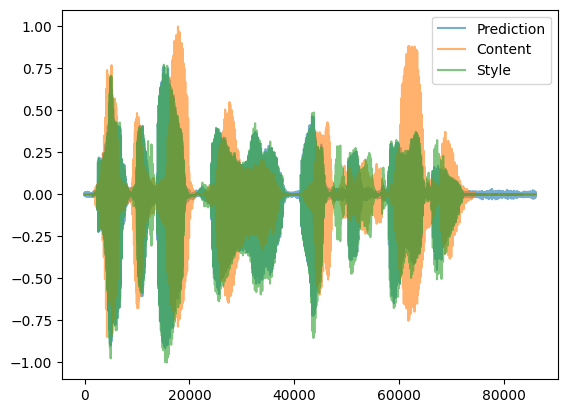

0.447: (1200) LR: [0.0005688000922764595] 
Total Loss:  0.00327477217069827
0.446: (1400) LR: [0.0005133420832795047] 
Total Loss:  0.003199810686055571
0.44: (1600) LR: [0.00046329123015975297] 
Total Loss:  0.003155178521410562
0.44: (1800) LR: [0.00041812033521917703] 
Total Loss:  0.003097029315540567
0.441: (2000) LR: [0.0003773536025353072] 
Total Loss:  0.003072607585636433


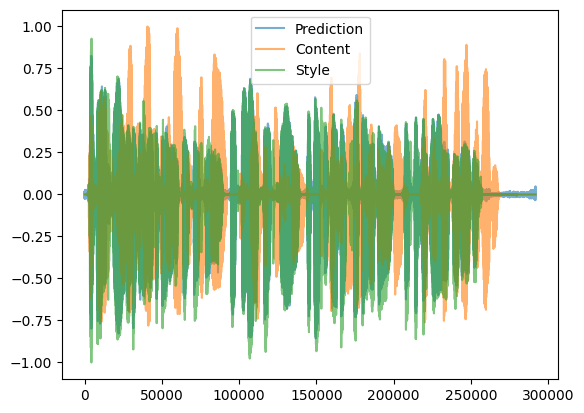

0.473: (2200) LR: [0.0003405616262881147] 
Total Loss:  0.003050702936889138
0.446: (2400) LR: [0.00030735686772502346] 
Total Loss:  0.003020033473148942
0.44: (2600) LR: [0.00027738957312183364] 
Total Loss:  0.0030161013200995512
0.447: (2800) LR: [0.0002503440897424548] 
Total Loss:  0.0029834572997060604
0.452: (3000) LR: [0.00022593554099256544] 
Total Loss:  0.0029707616376981605


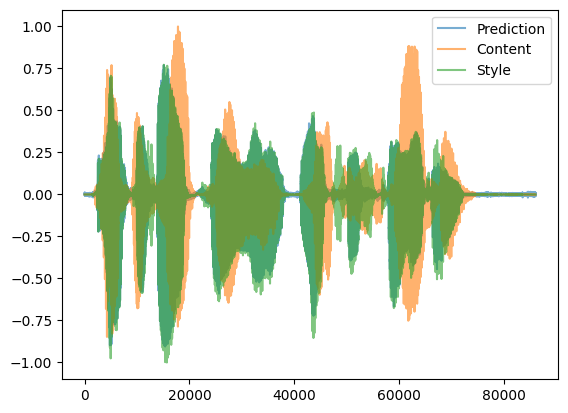

0.446: (3200) LR: [0.0002039068257457903] 
Total Loss:  0.0029577840941783506
0.437: (3400) LR: [0.00018402591023557573] 
Total Loss:  0.002942506984254578
0.438: (3600) LR: [0.00016608338398760707] 
Total Loss:  0.0029305997522897087
0.438: (3800) LR: [0.00014989025404881537] 
Total Loss:  0.0029206936560512986
0.441: (4000) LR: [0.00013527595427905584] 
Total Loss:  0.0029106076144671533


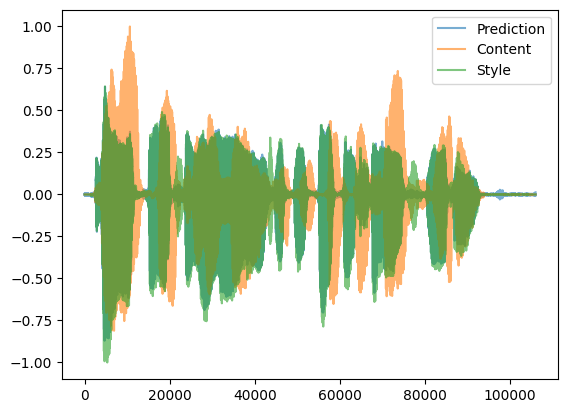

0.441: (4200) LR: [0.00012208654873684788] 
Total Loss:  0.002902466079831356
0.441: (4400) LR: [0.00011018311023500519] 
Total Loss:  0.002896973801398417
0.439: (4600) LR: [9.944025698709218e-05] 
Total Loss:  0.0028887041880807374
0.441: (4800) LR: [8.974483193085068e-05] 
Total Loss:  0.0028825574008806143
0.443: (5000) LR: [8.099471081759274e-05] 
Total Loss:  0.0028769201708200853


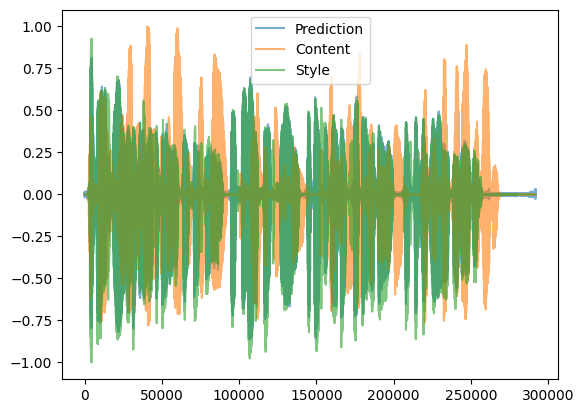

0.47: (5200) LR: [7.309772651287744e-05] 
Total Loss:  0.00287124215537915
0.442: (5400) LR: [6.597069817787189e-05] 
Total Loss:  0.002866446306143189
0.452: (5600) LR: [5.953855510552937e-05] 
Total Loss:  0.0028620525772566907
0.438: (5800) LR: [5.373354598274025e-05] 
Total Loss:  0.002857970252080122
0.435: (6000) LR: [4.849452524942307e-05] 
Total Loss:  0.002853883743227925


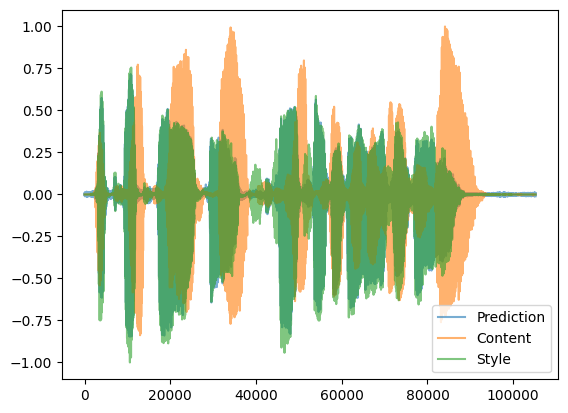

0.468: (6200) LR: [4.376630903760431e-05] 
Total Loss:  0.0028502835884864908
0.452: (6400) LR: [3.9499093906437885e-05] 
Total Loss:  0.0028469114768086
0.45: (6600) LR: [3.564793225056019e-05] 
Total Loss:  0.002843817161192419
0.439: (6800) LR: [3.2172258856130564e-05] 
Total Loss:  0.0028408311409293674
0.45: (7000) LR: [2.903546361765783e-05] 
Total Loss:  0.0028380055591696873


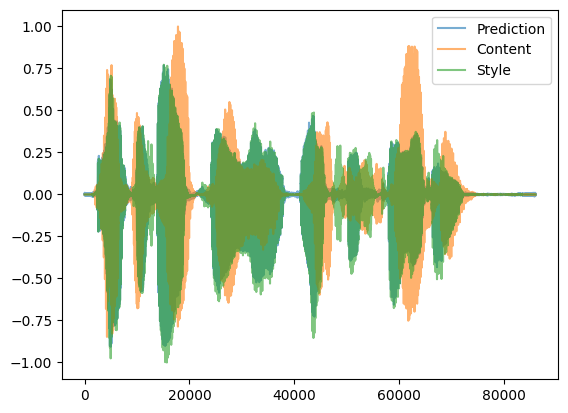

0.443: (7200) LR: [2.620450591493619e-05] 
Total Loss:  0.002835327497450635
0.434: (7400) LR: [2.364956658822991e-05] 
Total Loss:  0.002832749036315363
0.435: (7600) LR: [2.134373384587749e-05] 
Total Loss:  0.002830377077771118
0.431: (7800) LR: [1.9262719795904432e-05] 
Total Loss:  0.002828204676916357
0.433: (8000) LR: [1.738460461580375e-05] 
Total Loss:  0.002826153224305017


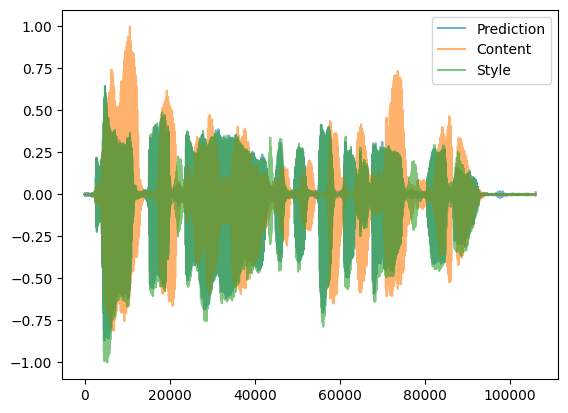

In [67]:
model = TinyModel().to(device)
model.train()
optim = torch.optim.AdamW(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.95)
#c_loss_func = CLoss(a1_t)
start_time = time.time()
scaler = torch.cuda.amp.GradScaler()
loss_fn = cdpam.CDPAM(dev='cuda:0')
for i in range(1,8000+1):
    optim.zero_grad()
    totloss=0
    for a1,a2 in loader: 
        a1_t = a1.to(device)
        a2_t = a2.to(device)
        #s_loss_func = SLoss(a2_t)
        #print(a1_t.shape,a2_t.shape)
        alpha = 1
        with torch.cuda.amp.autocast():
            prediction = model(a1_t)
        #print(prediction.shape)
        #c_loss = auraloss.time.ESRLoss()(torchaudio.functional.preemphasis(prediction),torchaudio.functional.preemphasis(a1_t))#c_loss_func(prediction) #F.l1_loss(prediction,a1_t)#c_loss_func(prediction)
        #s_loss = alpha * auraloss.time.ESRLoss()(torchaudio.functional.preemphasis(prediction),torchaudio.functional.preemphasis(a2_t)) #s_loss_func(prediction) #nn.MSELoss()(prediction,a2_t)#alpha *  s_loss_func(prediction)
        #pre,tar = auraloss.perceptual.FIRFilter().to(device)(prediction,a2_t)
        #esr = auraloss.time.ESRLoss()(prediction,a1_t)
        lcl = auraloss.time.LogCoshLoss(a=.5)(prediction,a2_t) 
        #mse = F.mse_loss(pre,tar)
        loss =   lcl #+ mse #s_loss #s_loss +  #s_loss_func(prediction) #auraloss.time.SISDRLoss()(torchaudio.functional.preemphasis(prediction),torchaudio.functional.preemphasis(a2_t)) #+ c_loss
        totloss += loss.item()
        scaler.scale(loss).backward()
        #break
    scaler.step(optim)
    scaler.update()
        #optim.step()

    if i % 200 == 0:
            print(f"{round((time.time()-start_time)/60,3)}: ({i}) LR:",scheduler.get_last_lr(), "\nTotal Loss: ",totloss)
            start_time = time.time()
    if i % 1000 == 0:
        plt.plot(prediction[0,0,:].detach().cpu().numpy(),alpha=.6,label='Prediction')
        plt.plot(a1_t[0,0,:].detach().cpu().numpy(),alpha=.6,label='Content')
        plt.plot(a2_t[0,0,:].detach().cpu().numpy(),alpha=.6,label='Style')
        plt.legend()
        plt.show()
    scheduler.step()
        


In [69]:
import wave
geni = 0
model.eval()
with torch.no_grad():
    for a1,a2 in loader: 
        a1_t = a1.to(device)
        a2_t = a2.to(device)

        with torch.cuda.amp.autocast():
            gen = model(a1_t)
        reconaudio = (np.array(gen.cpu().detach().numpy())*10000).astype(np.int16).flatten()
        filename = f"test_{geni}.wav"
        paudio = pyaudio.PyAudio()
        waveFile = wave.open(filename, 'wb')
        waveFile.setnchannels(CHANNELS)
        waveFile.setsampwidth(paudio.get_sample_size(FORMAT))
        waveFile.setframerate(RATE)
        waveFile.writeframes(b''.join(reconaudio))
        waveFile.close()
        geni+=1

In [51]:
W = prediction
kernel = 10
sma = nn.AvgPool1d(kernel_size=10, stride = 1)
out = sma(W)

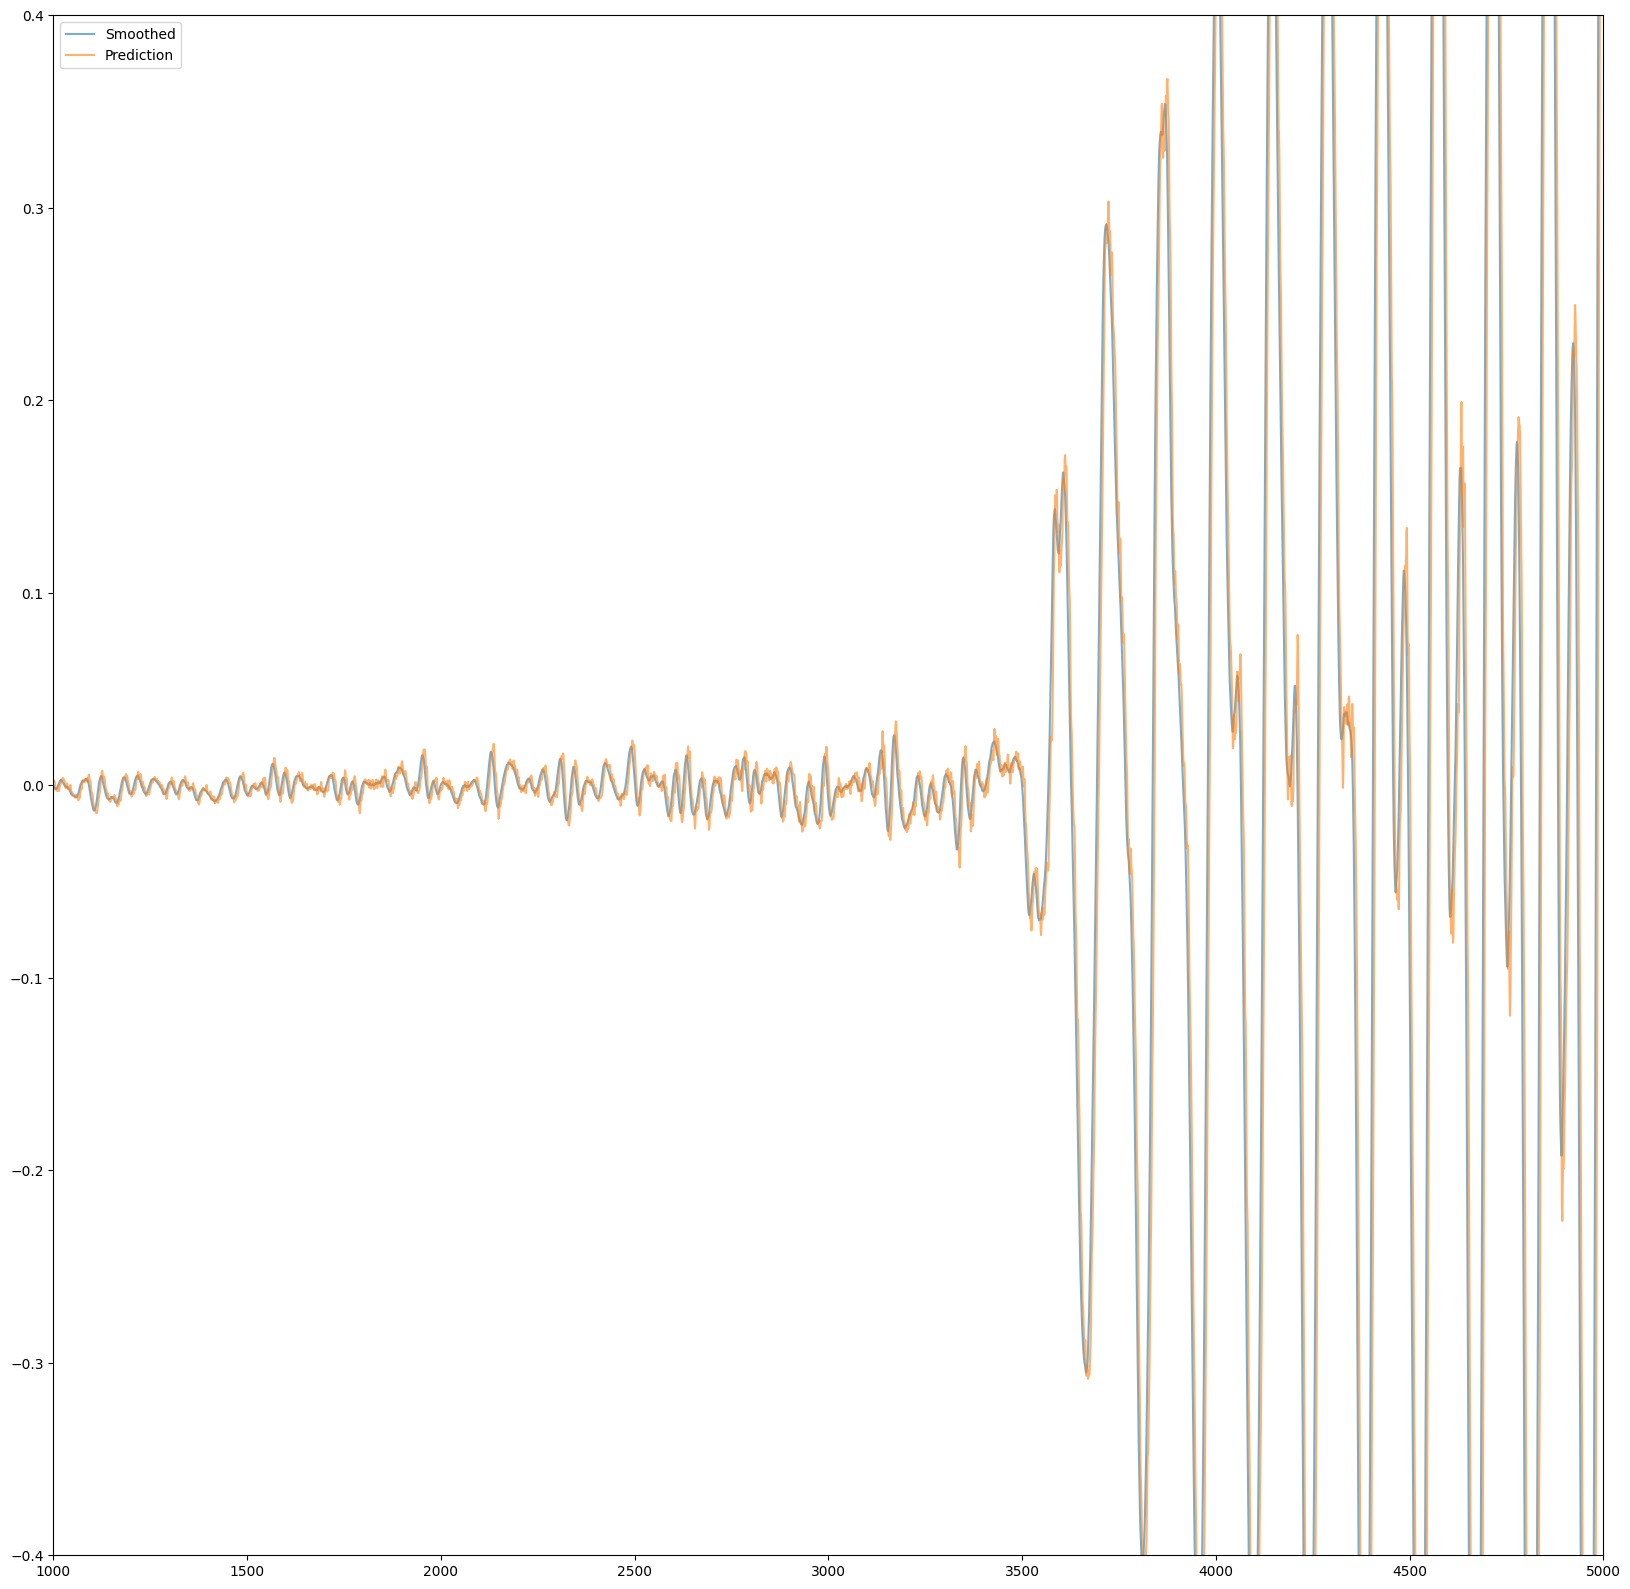

In [47]:
plt.figure(figsize=(20, 20))
plt.plot(out[0,0,:].detach().cpu().numpy(),alpha=.6,label='Smoothed')
plt.plot(prediction[0,0,:].detach().cpu().numpy(),alpha=.6,label='Prediction')
#plt.plot(a1_t[0,0,:].detach().cpu().numpy(),alpha=.6,label='Content')
#plt.plot(a2_t[0,0,:].detach().cpu().numpy(),alpha=.6,label='Style')
plt.xlim(1000,5000)
plt.ylim(-.4,.4)
plt.legend()
plt.show()

In [65]:
import wave
reconaudio = (np.array(prediction.cpu().detach().numpy())*10000).astype(np.int16).flatten()
filename = f"test.wav"
paudio = pyaudio.PyAudio()
waveFile = wave.open(filename, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(paudio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(reconaudio))
waveFile.close()

In [80]:
disc_fake = model(a1_t)
transform = torchaudio.transforms.MFCC(sample_rate=RATE,n_mfcc=13,melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}).to(device)
mfcc_predict = transform(disc_fake.flatten())
mfcc_orig = transform(a2_t.flatten())
loss = nn.L1Loss()(mfcc_predict,mfcc_orig)
loss.backward()
optim.step()

torch.Size([1, 1, 105216])


In [81]:
for param in model.parameters():
    print(param.grad)

tensor([[[ 3.3841e-01,  2.6150e-01,  2.9278e-01,  4.0097e-01,  4.4658e-01,
           4.1507e-01,  4.2011e-01,  4.8989e-01,  5.3868e-01]],

        [[ 9.9308e-02, -8.5710e-02, -1.2341e-01, -4.5371e-02, -7.8239e-02,
          -2.2393e-01, -2.5740e-01, -1.1291e-01,  2.5044e-02]],

        [[ 2.4062e-01,  1.3469e-01,  4.0165e-02,  8.3797e-02,  1.8725e-01,
           1.7718e-01,  5.4956e-02, -1.6439e-02,  4.8443e-02]],

        [[ 2.0532e-02, -1.6351e-01, -1.1073e-01, -4.5143e-03, -1.1034e-01,
          -3.0707e-01, -3.1984e-01, -1.8526e-01, -1.2971e-01]],

        [[-8.6022e-01, -8.1236e-01, -8.8776e-01, -9.8045e-01, -9.6053e-01,
          -9.4118e-01, -1.0526e+00, -1.1594e+00, -1.0945e+00]],

        [[-2.2989e-01, -1.9023e-01, -1.1097e-01, -1.2595e-01, -2.1015e-01,
          -1.5891e-01,  3.9625e-02,  1.2976e-01, -1.6752e-02]],

        [[-4.7352e-01, -5.9930e-01, -7.3021e-01, -8.1784e-01, -8.6511e-01,
          -9.0786e-01, -9.8848e-01, -1.1373e+00, -1.3268e+00]],

        [[-4.3631e-0

In [48]:
transform = torchaudio.transforms.MFCC(sample_rate=RATE,n_mfcc=13,melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}).to(device)
mfcc = transform(a1_t.flatten())

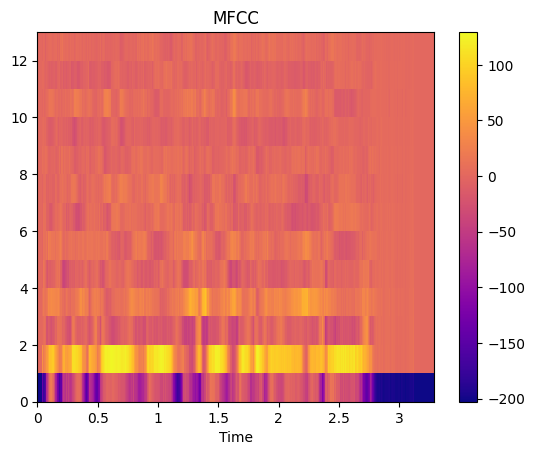

In [49]:
# Display
audio_len = a1_t.cpu().shape[-1]
# calculate x/y-coords
x_coords = np.linspace(0, audio_len / RATE, mfcc.cpu().shape[-1] + 1)

fig, ax = plt.subplots()
img = fill_spec(mfcc.cpu(), axes=ax,
                x_coords=x_coords, x_axis='time',
                title='MFCC')
fig.colorbar(img, ax=ax)

plt.show()

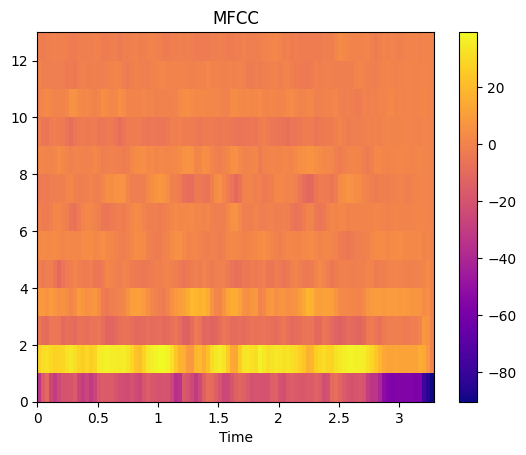

In [42]:
import numpy as np
import audioflux as af

import matplotlib.pyplot as plt
from audioflux.display import fill_spec

# Read audio data and sample rate
audio_arr, sr = a1_t.cpu().flatten(),RATE

# Extract mfcc
mfcc_arr, _ = af.mfcc(audio_arr, cc_num=13, mel_num=128, radix2_exp=12, samplate=sr)

# Display
audio_len = audio_arr.shape[-1]
# calculate x/y-coords
x_coords = np.linspace(0, audio_len / sr, mfcc_arr.shape[-1] + 1)

fig, ax = plt.subplots()
img = fill_spec(mfcc_arr, axes=ax,
                x_coords=x_coords, x_axis='time',
                title='MFCC')
fig.colorbar(img, ax=ax)

plt.show()

In [33]:
a1_t.shape

torch.Size([1, 105216])

In [34]:
105216/26301

4.000456256416106

In [35]:
model = TinyModel().to(device)
outpt = model(a1_t)

torch.Size([1, 105216])


In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t()) 

    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
          
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [36]:
res,loader = load_data(['Isabel_0','Kindred_1','Scout_9','Steve_10'])

Loading class Isabel_0...
Loading data from audio_data.gz
Loading class Kindred_1...
Loading data from audio_data.gz
Loading class Scout_9...
Loading data from audio_data.gz
Loading class Steve_10...
Loading data from audio_data.gz


In [37]:
batch_size = 1
train_ds = loader(res)
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel,self).__init__()
        self.CHUNK = 1024
        self.hidden_len = self.CHUNK
        self.lstm = nn.LSTM(self.CHUNK,self.hidden_len,1,batch_first=True)
    def forward(self,input):
        N,C,T = input.shape
        num_iters = T // self.CHUNK
        hidden = torch.zeros(N,1,self.hidden_len).to(input.device)
        cell = torch.zeros(N,1,self.hidden_len).to(input.device)
        output = torch.tensor([], dtype=torch.float32, device=input.device)
        for i in range(num_iters):
            input_chunk = input[:,:,i*self.CHUNK:(i+1)*self.CHUNK]
            #input_chunk = nn.ConstantPad1d((0, self.CHUNK - input_chunk.shape[2]), 0)(input_chunk)
            #print(input_chunk.shape)
            out,(hidden,cell) = self.lstm(input_chunk,(hidden,cell))
            output = torch.cat([output,out], dim=2)
        return output

In [40]:
import math
from tqdm import tqdm
import numpy as np

In [38]:
model = CustomModel().to(device)

In [41]:
model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,gamma=.995,step_size=5)
chunk = 1024

for epoch in range(10):
    avg_loss = []
    for audio,label in tqdm(train_loader,desc="Training"):
        audio = audio.to(device)
        audio = nn.ConstantPad1d((0, (math.ceil(audio.shape[2]/chunk))*chunk - audio.shape[2]), 0)(audio)
        label = label.to(device)
        #print(label.shape)
        #print(audio.shape)
        output = model(audio)
        #print(output.shape)
        optimizer.zero_grad()
        loss = nn.L1Loss()(output,audio)
        avg_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        #print(output.shape)
    print(f"Epoch {epoch+1} loss: {np.mean(avg_loss)}")
    scheduler.step()

model.eval()

Training: 100%|██████████| 72/72 [00:23<00:00,  3.05it/s]


Epoch 1 loss: 0.033619070736070476


Training: 100%|██████████| 72/72 [00:23<00:00,  3.08it/s]


Epoch 2 loss: 0.009282001488221189


Training: 100%|██████████| 72/72 [00:23<00:00,  3.04it/s]


Epoch 3 loss: 0.006932393757678155


Training: 100%|██████████| 72/72 [00:23<00:00,  3.02it/s]


Epoch 4 loss: 0.006085750815044675


Training: 100%|██████████| 72/72 [00:23<00:00,  3.02it/s]


Epoch 5 loss: 0.0055874844903074615


Training: 100%|██████████| 72/72 [00:23<00:00,  3.03it/s]


Epoch 6 loss: 0.005154930818308558


Training: 100%|██████████| 72/72 [00:23<00:00,  3.04it/s]


Epoch 7 loss: 0.005019224190618843


Training: 100%|██████████| 72/72 [00:22<00:00,  3.17it/s]


Epoch 8 loss: 0.004679296330626433


Training: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]


Epoch 9 loss: 0.004539634000846288


Training: 100%|██████████| 72/72 [00:23<00:00,  3.03it/s]

Epoch 10 loss: 0.004400499485200271


CustomModel(
  (lstm): LSTM(1024, 1024, batch_first=True)
)

: 

In [13]:
from scipy.io import wavfile
from pydub import AudioSegment
import sounddevice as sd
import wave
import numpy as np
import torchaudio
import os
import pathlib
import torch
from torch.utils.data import TensorDataset, DataLoader
import pyaudio
from torchvision import transforms
from math import ceil

import matplotlib.pyplot as plt
import custommodels as cm
import seaborn as sns

In [14]:
torch.cuda.is_available = lambda : True

In [15]:
OUTPUT_DEVICE = sd.default.device[1]
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE =  32000
CHUNK = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self,input_data,transform=None):
        self.input_data = input_data
        self.transform=transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        label = self.input_data[index][0]
        audiochunk = self.input_data[index][1]
        mfcc = self.input_data[index][2]
        if self.transform:
            audiochunk = self.transform(audiochunk)
        return audiochunk,mfcc,label

In [17]:
def make_chunks_torch(audio_segment, chunk_length):
    """
    Breaks an AudioSegment into chunks that are <chunk_length> milliseconds
    long.
    if chunk_length is 50 then you'll get a list of 50 millisecond long audio
    segments back (except the last one, which can be shorter)
    """
    number_of_chunks = ceil(audio_segment.shape[1] / float(chunk_length))
    for i in range(int(number_of_chunks)):
        yield audio_segment[0,i * chunk_length:(i + 1) * chunk_length]

In [39]:
audio_data = []
folder_labels = dict()
num_classes=0

folder = 'Audio' #Assume this is where all audio folders are located. This folder is at same level as script.
abspath = folder
subfolders = os.listdir(abspath)

trans = torchaudio.transforms.MFCC(RATE)
for audiogroup in subfolders:
    print("Folder:",audiogroup)
    if audiogroup in ['Isabel','Steve','1-Kindred']:
        files = os.listdir(os.path.join(abspath,audiogroup))
        folder_labels[audiogroup] = num_classes
        #print("\tFiles:",files)
        for file in files:
            relpath = os.path.join(os.path.join(abspath,audiogroup),file)
            #print(f"\t\tLoading {relpath}")
            data,samplerate = torchaudio.load(relpath,normalize=False)
            if samplerate!=RATE:
                data = torchaudio.transforms.Resample(samplerate,RATE)(data)
            data = torch.mean(data,dim=0).unsqueeze(0)
            data = data / torch.max(data)
            #data = (data - torch.mean(data)) / torch.std(data) 
            #data = torch.nn.functional.normalize(data)
            for chunk in make_chunks_torch(data,CHUNK):
                torchdatachunk = torch.cat([chunk,torch.zeros(CHUNK-len(chunk))])
                if torch.numel(torchdatachunk[torch.abs(torchdatachunk)>.001]) >= CHUNK//2: #remove silence
                    mfcc = trans(torchdatachunk)
                    torchdatachunk = torch.reshape(torchdatachunk,(1,-1))
                    audio_data.append((num_classes,torchdatachunk,mfcc))
            #torchdatachunk = torch.reshape(data,(1,-1))
            #audio_data.append((num_classes,torchdatachunk))
        num_classes+=1

batch_size = 32
train_ds = AudioDataset(audio_data)
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

Folder: 1-Kindred
Folder: Ashe
Folder: Diana
Folder: Draven
Folder: Ekko
Folder: Evelynn
Folder: Graves
Folder: Irelia
Folder: Isabel
Folder: Scout
Folder: Steve
Folder: Zagreus


<AxesSubplot: >

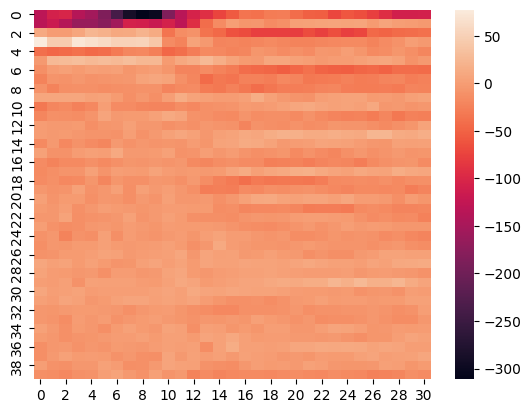

In [14]:
sns.heatmap(audio_data[8][2])
#plt.plot(audio_data[8][2].flatten())

In [26]:
def playAudio(audioflat):
    def make_chunks(audio_segment, chunk_length):
        """
        Breaks an AudioSegment into chunks that are <chunk_length> milliseconds
        long.
        if chunk_length is 50 then you'll get a list of 50 millisecond long audio
        segments back (except the last one, which can be shorter)
        """
        number_of_chunks = ceil(len(audio_segment) / float(chunk_length))
        for i in range(int(number_of_chunks)):
            yield audio_segment[i * chunk_length:(i + 1) * chunk_length]
    p = pyaudio.PyAudio()
    outputstream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    output_device_index=OUTPUT_DEVICE,
                    output=True,start=False)

    outputstream.start_stream()


    seg = AudioSegment(
        audioflat.tobytes(), 
        frame_rate=RATE,
        sample_width=pyaudio.get_sample_size(FORMAT), 
        channels=CHANNELS
    )
    for chunk in make_chunks(seg,CHUNK):
        outputstream.write(chunk._data)

    outputstream.stop_stream()

In [37]:
def convAudio(audiobit):
    return (audiobit.numpy()*1000).astype(np.int16).flatten()

In [50]:
playAudio(convAudio(audio_data[54][1][0]))

## AzureML

In [1]:
from azureml.core import Workspace, Dataset, Environment
from azureml.core import Dataset, Datastore
# Load the stored workspace
subscription_id = '19b6de0a-2b5c-4bde-8c91-fee11f907591'
resource_group = 'machinelearning'
workspace_name = 'azureml'

# create the Workspace
ws = Workspace.get(workspace_name,
    subscription_id=subscription_id, 
    resource_group=resource_group,
)


datastore = ws.get_default_datastore()
# Get the registered dataset from azure
#dataset = Dataset.get_by_name(ws, name='waste_images')

## Try with our saved image
env = Environment.get(workspace=ws, name="AzureML-ACPT-pytorch-1.12-py39-cuda11.6-gpu")

In [10]:
file_dataset = Dataset.File.from_files(path=(datastore, 'Audio/**'))
dataset_input = file_dataset.as_mount()

In [ ]:
from azureml.core.compute import ComputeTarget
compute_name = ""
compute_target = ComputeTarget(workspace=ws, name=compute_name)
       

In [ ]:
from azureml.core import ScriptRunConfig

# setup the run details
src = ScriptRunConfig(source_directory='train_script',
                      script='train.py',
                      arguments=['--data-path', dataset_input],
                      compute_target=compute_target,
                      environment=env)

## Run Models

In [107]:
import custommodels as cm
import math
model = cm.SimpleRNN(CHUNK,skip=0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0004)
model.train()
loss_func = auraloss.time.ESRLoss()


for label,sample in audio_data:
    ep_loss = 0
    optimizer.zero_grad()
    model.zero_grad()


    batch_loss = 0
    start_i = 0
    up_fr = CHUNK
    # Iterate over the remaining samples in the mini batch
  
    for k in range(math.ceil((sample.shape[-1])-200)//up_fr):
        audsample = sample[:,start_i:start_i + up_fr].to(device)

        output = model(audsample)
        # Calculate loss and update network parameters
        loss = loss_func(output, audsample)
        loss.backward()
        optimizer.step()

        # Set the network hidden state, to detach it from the computation graph
        model.detach_hidden()
        model.zero_grad()

        # Update the start index for the next iteration and add the loss to the batch_loss total
        start_i += up_fr
        batch_loss += loss

    # Add the average batch loss to the epoch loss and reset the hidden states to zeros
    ep_loss += batch_loss / (k + 1)
    print(ep_loss)
    model.reset_hidden()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
from tqdm import tqdm

Epoch: 0
386 iterations g: 9.049519538879395 d: 2.2958898544311523



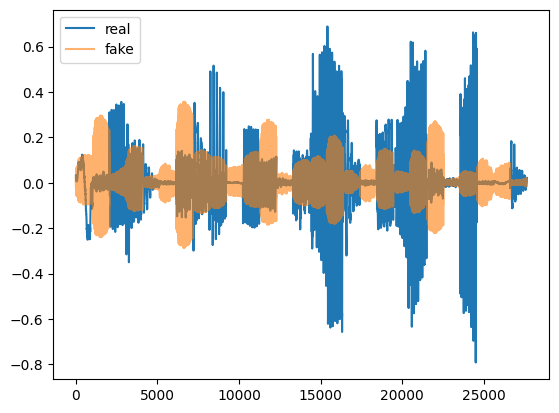

Epoch: 100
38886 iterations g: 27.204282760620117 d: 0.5262529850006104


KeyboardInterrupt: 

In [40]:
import custommodels as cm
import melgan as mg
#import cdpam
#loss_fn = cdpam.CDPAM()


model_g = mg.Generator(audio_data[0][2].shape[0],num_classes).to(device)
model_d = mg.MultiScaleDiscriminator(num_classes).to(device)

optim_g = torch.optim.Adam(model_g.parameters(),lr=0.0001,betas=(0.5,.9))
optim_d = torch.optim.Adam(model_d.parameters(),lr=0.0001,betas=(0.5,.9))

model_g.train()
model_d.train()

i=0
max_epochs = 6300
for epoch in range(max_epochs):
    for real_audio,mfcc,labels in tqdm(train_loader,desc=f"Epoch {epoch+1}"):
        real_audio = real_audio.to(device)
        mfcc = mfcc.to(device)
        labels = labels.to(device)

       # generator
        optim_g.zero_grad()
        fake_audio = model_g(mfcc,labels)[:, :, :CHUNK]
        disc_fake = model_d(fake_audio,labels)
        disc_real = model_d(real_audio,labels)
        loss_g = 0.0
        #print(loss_fn.forward(real_audio[0],fake_audio[0]),loss_fn.forward(fake_audio[0],real_audio[0]))
        #for r,f in zip(real_audio,fake_audio):
        #    loss_g += loss_fn.forward(r,f)

        for (feats_fake, score_fake), (feats_real, _) in zip(disc_fake, disc_real):
            loss_g += torch.mean(torch.sum(torch.pow(score_fake - 1.0, 2), dim=[1, 2]))
            for feat_f, feat_r in zip(feats_fake, feats_real):
                loss_g += 10 * torch.mean(torch.abs(feat_f - feat_r))
        loss_g.backward()
        optim_g.step()

        # discriminator
        fake_audio = model_g(mfcc,labels)[:, :, :CHUNK]
        fake_audio = fake_audio.detach()
        loss_d_sum = 0.0
        for _ in range(2):
            optim_d.zero_grad()
            disc_fake = model_d(fake_audio,labels)
            #print(disc_fake)
            #print(disc_fake[0][0][1].shape)
            disc_real = model_d(real_audio,labels)
            loss_d = 0.0
            for (_, score_fake), (_, score_real) in zip(disc_fake, disc_real):
                loss_d += torch.mean(torch.sum(torch.pow(score_real - 1.0, 2), dim=[1, 2]))
                loss_d += torch.mean(torch.sum(torch.pow(score_fake, 2), dim=[1, 2]))

            loss_d.backward()
            optim_d.step()
            loss_d_sum += loss_d


        i+=1
    if epoch %100 == 0:
        print("Epoch:",epoch)
        print('%d iterations' % (i+1), 'g:',loss_g.item(),'d:',loss_d.item())
    if epoch%500==0:
        print() 
        flatreal = real_audio.detach().cpu().numpy().flatten()
        fakereal = fake_audio.detach().cpu().numpy().flatten()
        plt.plot(flatreal,label='real') 
        plt.plot(fakereal,label='fake',alpha=.6)
        plt.legend()
        plt.show()

In [416]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

7299599872
7887388672


c:\Users\irose\miniconda3\envs\audioai\lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [390]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Check Audio Output

In [20]:
def make_chunks(audio_segment, chunk_length):
    """
    Breaks an AudioSegment into chunks that are <chunk_length> milliseconds
    long.
    if chunk_length is 50 then you'll get a list of 50 millisecond long audio
    segments back (except the last one, which can be shorter)
    """
    number_of_chunks = ceil(len(audio_segment) / float(chunk_length))
    for i in range(int(number_of_chunks)):
        yield audio_segment[i * chunk_length:(i + 1) * chunk_length]

In [47]:
folder_labels

{'1-Kindred': 0, 'Isabel': 1, 'Steve': 2}

In [60]:
testdata = []
abspath = 'Audio'
audiogroup = "Isabel" #"1-Kindred"
print("Folder:",audiogroup)
files = os.listdir(os.path.join(abspath,audiogroup))
i = folder_labels[audiogroup]
file = "chairwiki.wav" #"Kindred.mark05.wav"

relpath = os.path.join(os.path.join(abspath,audiogroup),file)
#print(f"\t\tLoading {relpath}")
data,samplerate = torchaudio.load(relpath,normalize=False)
if samplerate!=RATE:
    data = torchaudio.transforms.Resample(samplerate,RATE)(data)
data = torch.mean(data,dim=0).unsqueeze(0)
data = data / torch.max(data)

#data = (data - torch.mean(data)) / torch.std(data) 
#data = torch.nn.functional.normalize(data)

for chunk in make_chunks_torch(data,CHUNK):
    torchdatachunk = torch.cat([chunk,torch.zeros(CHUNK-len(chunk))])
    mfcc = trans(torchdatachunk)
    torchdatachunk = torch.reshape(torchdatachunk,(1,-1))
    testdata.append((i,torchdatachunk,mfcc))

batch_size = 32
test_ds = AudioDataset(testdata)
test_loader = DataLoader(test_ds, batch_size=batch_size,shuffle=False)

Folder: Isabel


### Actual Audio:

In [42]:
fullaudio = []
for audiochunk in testdata:
    fullaudio += list(audiochunk[1].detach().cpu().numpy())
fullaudio = (np.array(fullaudio)*5000).astype(np.int16).flatten()

In [43]:
playAudio(fullaudio)

KeyboardInterrupt: 

### Reconstructed Audio:

In [61]:
reconaudio = []
with torch.no_grad():
    for true_audio,mfcc,labels in test_loader:
        true_audio= true_audio.to(device)
        mfcc = mfcc.to(device)
        labels = labels.to(device)
        
        recon = model_g(mfcc,labels)[:, :, :CHUNK]
        reconaudio += list(recon.detach().cpu().numpy())
    reconaudio = (np.array(reconaudio)*5000).astype(np.int16).flatten()

In [50]:
playAudio(reconaudio)

KeyboardInterrupt: 

In [248]:
filename = "F:\AudioAI\soundsample2.wav"
paudio = pyaudio.PyAudio()
waveFile = wave.open(filename, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(paudio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(reconaudio))
waveFile.close()

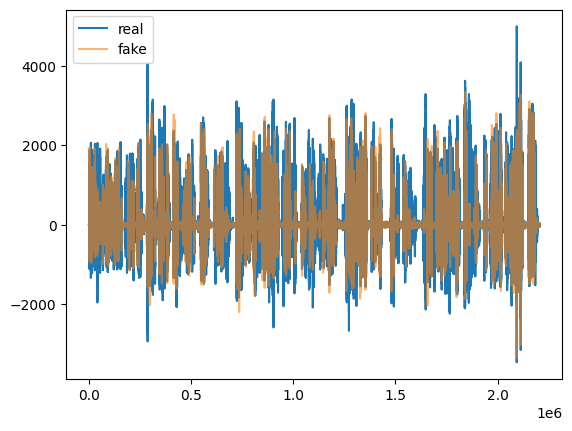

In [46]:
plt.plot(fullaudio,label='real')
plt.plot(reconaudio,label='fake',alpha=.6)
plt.legend()

In [62]:
test1 = reconaudio

In [59]:
test2 = reconaudio

In [63]:
test1

array([ -7,  -1,  -9, ..., -10,  13,  13], dtype=int16)

In [68]:
np.unique(test2 == test1)

array([False,  True])

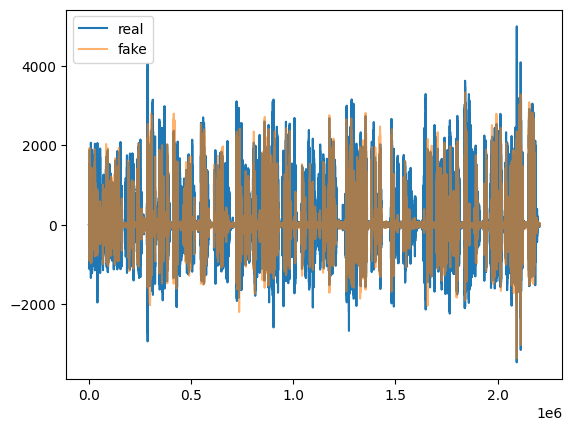

In [57]:
plt.plot(fullaudio,label='real')
plt.plot(reconaudio,label='fake',alpha=.6)
plt.legend()